# DroneMotion

## Kernel Mode

### Import Statements

In [1]:
# Import pytorch
from torchvision.transforms import Compose, CenterCrop, Scale
from torchvision.transforms import ToTensor, Normalize
from torch.nn import Linear, CrossEntropyLoss, Softmax
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from torch import max, sum, save, load

In [2]:
# Import other
from cv2 import VideoCapture, imwrite
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from __future__ import division
from os.path import isdir, join
from os import makedirs, system
from IPython import display
from copy import deepcopy
import numpy as np

### Function Declarations

In [3]:
################################################################################
# Description:  Captures frames of a single type of movement and save them.
# Function:     capture_movement
# Inputs:       move         (movement name)
#               movement_dir (movement directory path)
# Outputs:      none
################################################################################
def capture_movement(move, movement_dir='movements'):
    
    # Check for movement directory
    if not isdir(movement_dir):
        makedirs(movement_dir)
        
    # Check for move directory
    if not isdir(join(movement_dir, move)):
        makedirs(join(movement_dir, move))
        
    # Capture movement
    index = 0
    capture = VideoCapture(0)
    
    # Adjust light levels
    for frame in range(10):
        _, frame = capture.read()
    
    # Capture a certain number of frames
    for frame in range(10):
        _, frame = capture.read()
        image_name = move + '_' + str(index) + '.png'
        imwrite(join(movement_dir, move, image_name), frame)
        index += 1
    capture.release()
    
    # Display one sample frame
    plt.imshow(plt.imread(join(movement_dir, move, image_name)))

In [4]:
################################################################################
# Description:  Train neural network model
# Function:     train_nn
# Inputs:       model      (model to be trained)
#               model_name (name of file to save model)
#               loader     (data loader)
#               size       (size of training data set)
#               criterion  (loss function)
#               optimizer  (optimizer for training)
#               epochs     (number of epochs)
# Outputs:      best_model (model with best loss)
################################################################################
def train_nn(model, model_name, loader, size, criterion, optimizer, epochs):
    
    # Initialize training variables
    best_model = model
    best_loss = float("inf")
    losses = []
    accuracies = []

    # Iterate over epochs
    for epoch in range(epochs):
        print ('Epoch {}/{}'.format(epoch + 1, epochs))
        print ('-' * 10)

        # Initialize epoch variables
        running_loss = 0.0
        running_corrects = 0

        # Iterate over batches of data
        for batch in loader:
            
            # Acquire batch of data
            inputs, labels = batch
            inputs, labels = Variable(inputs), Variable(labels)

            # Forward Propagation
            optimizer.zero_grad()
            outputs = model(inputs)

            # Backward Propagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update epoch variables
            _, predictions = max(outputs.data, 1)
            running_corrects += sum(predictions == labels.data)
            running_loss += loss.data[0]

        # Calculate epoch statistics
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        print ('Loss: {:.4f} Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
        print ('')

        # Save if best model
        if epoch_loss < best_loss:
            best_model = deepcopy(model)
            best_loss = epoch_loss
            
        # Stopping condition
        if best_loss < 0.0001:
            break

    # Output , save
    print ('Training Complete - Loss: {:4f}'.format(best_loss))
    save(best_model, model_name + '.pth')
    
    # Plot Training Loss
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    
    # Plot Training Accuracy
    plt.figure()
    plt.plot(accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    
    return best_model

In [5]:
################################################################################
# Description:  Processes captured movements and calibrates sensor.
# Function:     calibrate_sensor
# Inputs:       movement_dir (movement directory path)
# Outputs:      sensor       (calibrated sensor)
################################################################################
def calibrate_sensor(movement_dir='movements'):
    
    # Data transformation and augmentation
    transform = Compose([CenterCrop(720), Scale(224), 
                         ToTensor(), Normalize([0.485, 0.456, 0.406],
                                               [0.229, 0.224, 0.225])])
    
    # Initialize model arguments
    model = load('./droneMotion.pth')
    model_name = 'droneMotion'
    
    # Initialize data arguments
    dataset = ImageFolder(movement_dir, transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    size = len(dataset)
    
    # Initialize training arguments
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters())
    epochs = 25
    
    # Train and return neural network
    return train_nn(model, model_name, loader, size, criterion, optimizer, epochs)

In [6]:
################################################################################
# Description:  Implementation of discrete bayes filter.
# Function:     discrete_bayes_filter 
# Inputs:       p (prior probability distribution)
#               z (sensor probability distribution)
#               t (transition matrix)
# Outputs:      p (posterior probability distribution)
################################################################################
def discrete_bayes_filter(p, z, t):
    p = z * np.sum(t * p, axis=1)
    p /= np.sum(p)
    return p

In [7]:
################################################################################
# Description:  Uses sensor to allow the user to fly a drone using hand motions
# Function:     fly_drone  
# Inputs:       none
# Outputs:      none
################################################################################
def fly_drone():
    
    # Drone moves
    moves = ['land', 'move_backward','move_forward', 'move_left',
             'move_right', 'rotate_left', 'rotate_right', 'stop']
    
     # Data transformation
    transform = Compose([CenterCrop(720), Scale(224),
                         ToTensor(), Normalize([0.485, 0.456, 0.406],
                                               [0.229, 0.224, 0.225])])
    
    # Initialize bayes filter variables
    p = np.array([0.125] * 8)
    t = np.full((8, 8), 0.01 / 7)
    np.fill_diagonal(t, 0.99)
    
    # Initialize model variables
    softmax = Softmax()
    model = load('./droneMotion.pth')
    model.eval()
    move = -1
    
    # Turn on motion sensor
    capture = VideoCapture(0)
    plt.ion()
    while (True):
        
        # Plot probability distribution
        plt.cla()
        plt.bar(range(len(p)), p, color='blue')
        plt.xticks(range(len(p)), ['land', 'back','forw', 'left',
                                   'right', 'rleft', 'rright', 'stop'])
        plt.ylabel('Probability')
        plt.ylim([0, 1.19])
        plt.pause(1e-10)
        
        # Capture and process frame
        _, frame = capture.read()
        image = frame[:,:,::-1]
        image = fromarray(image)
        image = transform(image)
        image = image.unsqueeze(0)
        image = Variable(image)
        
        # Forward propagation and bayesian estimate
        outputs = model(image)
        z = softmax(outputs).data.numpy()[0]
        p = discrete_bayes_filter(p, z, t)
        
        # Enforce 99% accuracy threshold, otherwise stop
        if np.max(p) >= .99 and move != np.argmax(p):
            move = np.argmax(p)
            system("say '" + moves[move] + "'")  
        elif np.max(p) < .99 and move != -1:
            move = -1
    capture.release()

## User Mode

In [8]:
%matplotlib inline

### Acquire data for calibration

Each cell below captures some calibration data required for a move. You will have to run each cell one at a time to capture the movement requested (capture_movement('REQUESTED MOVEMENT')). You will most likely need some assistance capturing this footage by having somebody run the cells. Each movement requires less than a second of video. Please follow our online guidelines on how to be positioned in the video frame.

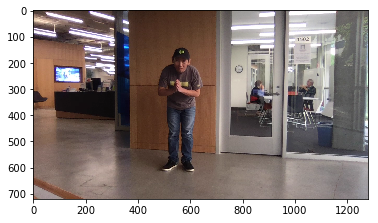

In [9]:
capture_movement('land')

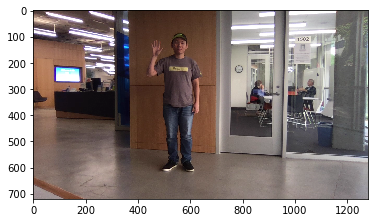

In [10]:
capture_movement('move_backward')

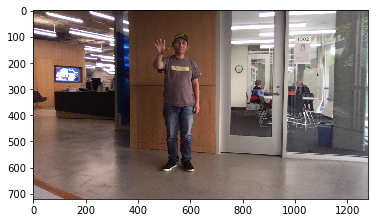

In [11]:
capture_movement('move_forward')

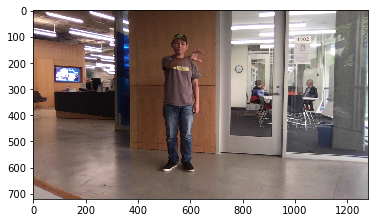

In [12]:
capture_movement('move_left')

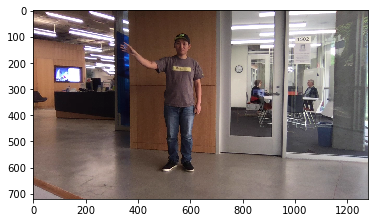

In [13]:
capture_movement('move_right')

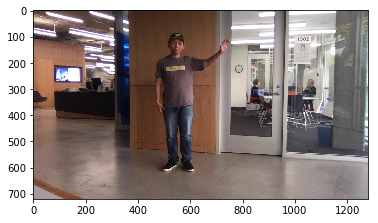

In [14]:
capture_movement('rotate_left')

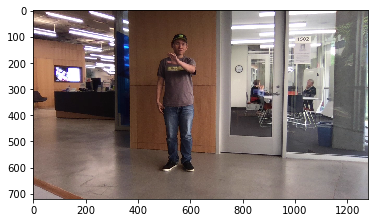

In [15]:
capture_movement('rotate_right')

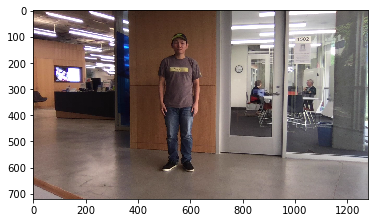

In [16]:
capture_movement('stop')

### Calibrate "Sensor"

Run this cell below to use the acquired data above to calibrate the system. This may take a few minutes. If it has been more than five minutes, it may help to restart this notebook.

Epoch 1/25
----------
Loss: 0.0373 Accuracy: 0.8750

Epoch 2/25
----------
Loss: 0.0031 Accuracy: 1.0000

Epoch 3/25
----------
Loss: 0.0012 Accuracy: 1.0000

Epoch 4/25
----------
Loss: 0.0011 Accuracy: 1.0000

Epoch 5/25
----------
Loss: 0.0005 Accuracy: 1.0000

Epoch 6/25
----------
Loss: 0.0002 Accuracy: 1.0000

Epoch 7/25
----------
Loss: 0.0002 Accuracy: 1.0000

Epoch 8/25
----------
Loss: 0.0002 Accuracy: 1.0000

Epoch 9/25
----------
Loss: 0.0002 Accuracy: 1.0000

Epoch 10/25
----------
Loss: 0.0001 Accuracy: 1.0000

Epoch 11/25
----------
Loss: 0.0001 Accuracy: 1.0000

Training Complete - Loss: 0.000083


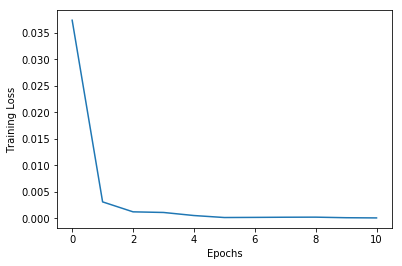

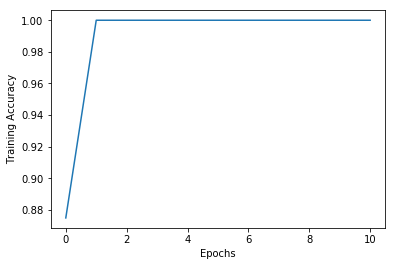

In [17]:
sensor = calibrate_sensor()

### Fly with the force

In [18]:
%matplotlib

Using matplotlib backend: MacOSX


Run this cell below to demo the hand gesture detection system. This demo will work in real-time by using your computer's webcam. Please position yourself as you did for the calibration data. For better results, the position of the computer and user should not change from calibration to the live demo. Also, movements should ideally replicate those performed during calibration. There will be an audible feedback along with a dynamic bar chart from the system.

In [ ]:
fly_drone()